# GNN Drug Discovery - Toxicity Prediction

The Deepchem and dataset setup below was taken from the official tutorial: [link ](https://github.com/deepchem/deepchem/blob/master/examples/tutorials/03_Modeling_Solubility.ipynb)

The code is a modified version of this [file](https://github.com/deepchem/deepchem/blob/master/examples/tox21/tox21_tensorgraph_graph_conv.py).

In [1]:
# Installing Deepchem
!pip install --pre deepchem
# Import deepchem just to check the version
import deepchem
deepchem.__version__

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 773.0/773.0 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 20.5 MB/s eta 0:00:00


'2.7.2.dev'

In [19]:
# Importing required libraries and its utilities
import random
random.seed(155)
import numpy as np
np.random.seed(155)
import tensorflow as tf
tf.random.set_seed(155)
import deepchem as dc
from deepchem.molnet import load_tox21
from deepchem.models.graph_models import GraphConvModel

# Data

The Tox21 dataset is a collection of chemical compounds and their associated toxicological effects. It includes binary labels indicating whether a compound is active or inactive with respect to 12 protein targets in the human body, as well as molecular descriptors for each compound. It has been widely used as a benchmark for the development of machine learning models for toxicity prediction.

Get and analyze the data of the tox21 dataset

In [20]:
import requests
import pandas as pd

url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz"
filename = url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)

tox21_dataset = pd.read_csv(filename)

In [21]:
tox21_dataset.head()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O


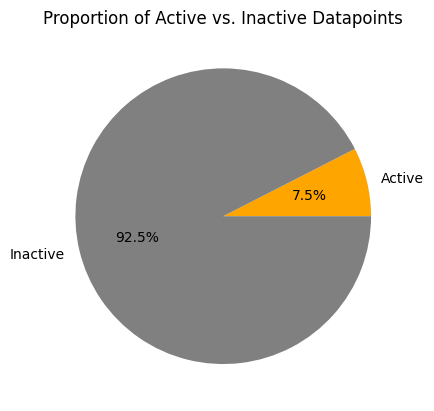

In [48]:
import matplotlib.pyplot as plt

# Define the number of active and inactive datapoints
num_active = (tox21_dataset == 1).sum().sum()
num_inactive = (tox21_dataset == 0).sum().sum()

# Create a pie chart showing the proportion of active vs. inactive datapoints
labels = ['Active', 'Inactive']
sizes = [num_active, num_inactive]
colors = ['orange', 'gray']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')

# Set the title of the chart
plt.title('Proportion of Active vs. Inactive Datapoints')

# Show the chart
plt.show()

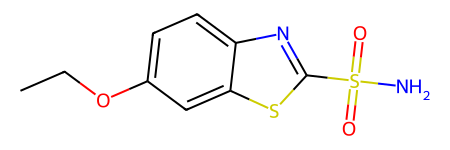

In [44]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

# Define the SMILES string
smiles = tox21_dataset.smiles[0]

# Convert the SMILES string to a molecule object
mol = Chem.MolFromSmiles(smiles)

# Visualize the molecule using RDKit
mol

# DeepChem

DeepChem is a popular open-source Python library for deep learning in drug discovery, materials science, and biology. It provides a wide range of tools and models for working with molecular data, including chemical fingerprints, molecular graphs, and protein sequences. DeepChem supports a variety of deep learning frameworks, including TensorFlow and PyTorch, and includes pre-trained models for a range of tasks, such as molecule generation, property prediction, and bioactivity classification.

## MultiTaskClassifier Using Molecular Fingerprints

A molecular fingerprint is a method of encoding the structural information of a molecule as a fixed-length vector of binary or integer values. The molecular fingerprint is typically used as a descriptor of the molecule in cheminformatics and machine learning applications.

There are many different types of molecular fingerprints, but they all aim to capture some aspect of the molecular structure or properties that is relevant for the specific application. For example, some molecular fingerprints are based on the presence or absence of specific substructures or functional groups in the molecule, while others are based on the 2D or 3D topology of the molecule.

One common use case for molecular fingerprints is virtual screening, where a large database of compounds is searched for molecules that are similar to a known active compound or pharmacophore. The molecular fingerprints of the compounds in the database can be compared to the query fingerprint using a similarity metric such as the Tanimoto coefficient, and the top-scoring hits can be further analyzed or tested in experiments.

In [28]:
tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='ECFP')
train_dataset, valid_dataset, test_dataset = datasets
print(train_dataset)

<DiskDataset X.shape: (6264, 1024), y.shape: (6264, 12), w.shape: (6264, 12), task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>


ECFP (Extended Connectivity Fingerprint) is a molecular fingerprinting method that encodes the structural information of a molecule as a binary vector. The ECFP fingerprint of a molecule is computed by recursively encoding the connectivity of its atoms into a fixed-length bit vector, where each bit represents the presence or absence of a particular substructure.

In [50]:
print(transformers)

This transformer balances the number of positive and negative examples for each task in the dataset, by oversampling the minority class or undersampling the majority class

In [40]:
model = dc.models.MultitaskClassifier(n_tasks=12, n_features=1024, layer_sizes=[1000], batch_size=32) # Fully connected network with 1 dense layer of 1000

In [41]:
import numpy as np

model.fit(train_dataset, nb_epoch=10)
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
print('training set score:', model.evaluate(train_dataset, [metric], transformers))
print('test set score:', model.evaluate(test_dataset, [metric], transformers))

training set score: {'roc_auc_score': 0.9716500509164768}
test set score: {'roc_auc_score': 0.6796278022752703}


## Graph Convolutional Network

A graph convolutional network (GCN) is a neural network designed to work with graph-structured data. GCNs use a message passing scheme to propagate information between the nodes of the graph, and apply convolutional filters to extract features from the local graph neighborhoods. The key idea is to define a graph convolution operation that combines the features of neighboring nodes into a new feature vector for each node

In [51]:
tox21_tasks, tox21_datasets, transformers = load_tox21(featurizer='GraphConv') # TODO what does this exactly does, how does it process to be the graph for graphconv GraphData is object
train_dataset, valid_dataset, test_dataset = tox21_datasets

In [53]:
# Define metric for the model
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, 
                           task_averager=np.mean, # average across 12 tasks
                           mode="classification")


In [54]:
# Define and fit the model
model = GraphConvModel(len(tox21_tasks), 
                       batch_size=32, 
                       mode='classification')
print("Fitting the model")
model.fit(train_dataset, nb_epoch=10) # TODO which loss used


Fitting the model


0.6991443634033203

In [11]:
print("Evaluating model with ROC AUC")
train_scores = model.evaluate(train_dataset, [metric], transformers)
valid_scores = model.evaluate(valid_dataset, [metric], transformers)

Evaluating model with ROC AUC


In [12]:
print("Train scores")
print(train_scores)

print("Validation scores")
print(valid_scores)

Train scores
{'mean-roc_auc_score': 0.8902731707769181}
Validation scores
{'mean-roc_auc_score': 0.7279278872190327}


# Our Graph Convolutional Model

In [86]:
class OurGraphPool(tf.keras.layers.Layer):
    """A GraphPool gathers data from local neighborhoods of a graph.
    This layer does a max-pooling over the feature vectors of atoms in a
    neighborhood. You can think of this layer as analogous to a max-pooling
    layer for 2D convolutions but which operates on graphs instead. This
    technique is described in [1]_.
    References
    ----------
    .. [1] Duvenaud, David K., et al. "Convolutional networks on graphs for
        learning molecular fingerprints." Advances in neural information processing
        systems. 2015. https://arxiv.org/abs/1509.09292
    """

    def __init__(self, reducer="max", min_degree=0, max_degree=10, **kwargs):
        """Initialize this layer
        Parameters
        ----------
        min_deg: int, optional (default 0)
            The minimum allowed degree for each graph node.
        max_deg: int, optional (default 10)
            The maximum allowed degree for each graph node. Note that this
            is set to 10 to handle complex molecules (some organometallic
            compounds have strange structures). If you're using this for
            non-molecular applications, you may need to set this much higher
            depending on your dataset.
        """
        super().__init__(**kwargs)
        self.min_degree = min_degree
        self.max_degree = max_degree
        self.reducer = reducer

    def get_config(self):
        config = super(GraphPool, self).get_config()
        config['min_degree'] = self.min_degree
        config['max_degree'] = self.max_degree
        config['reducer'] = self.reducer
        return config

    def call(self, inputs):
        atom_features = inputs[0]
        deg_slice = inputs[1]
        deg_adj_lists = inputs[3:]

        # Perform the mol gather
        # atom_features = graph_pool(atom_features, deg_adj_lists, deg_slice,
        #                            self.max_degree, self.min_degree)

        deg_reduced = (self.max_degree + 1 - self.min_degree) * [None]

        # Tensorflow correctly processes empty lists when using concat

        split_features = tf.split(atom_features, deg_slice[:, 1])
        for deg in range(1, self.max_degree + 1):
            # Get self atoms
            self_atoms = split_features[deg - self.min_degree]

            if deg_adj_lists[deg - 1].shape[0] == 0:
                # There are no neighbors of this degree, so just create an empty tensor directly.
                reduced_atoms = tf.zeros((0, self_atoms.shape[-1]))
            else:
                # Expand dims
                self_atoms = tf.expand_dims(self_atoms, 1)

                # always deg-1 for deg_adj_lists
                gathered_atoms = tf.gather(atom_features,
                                           deg_adj_lists[deg - 1])
                gathered_atoms = tf.concat(axis=1,
                                           values=[self_atoms, gathered_atoms])

                if self.reducer=="max":
                  reduced_atoms = tf.reduce_max(gathered_atoms, 1)
                elif self.reducer=="mean":
                  reduced_atoms = tf.reduce_mean(gathered_atoms, 1)
                elif self.reducer=="sum":
                  reduced_atoms = tf.reduce_sum(gathered_atoms, 1)
                else:
                  print("Wrong reducer specified")
            deg_reduced[deg - self.min_degree] = reduced_atoms

        if self.min_degree == 0:
            self_atoms = split_features[0]
            deg_reduced[0] = self_atoms

        return tf.concat(axis=0, values=deg_reduced)

In [87]:
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow as tf
import tensorflow.keras.layers as layers

from deepchem.metrics import to_one_hot
from deepchem.feat.mol_graphs import ConvMol
import numpy as np


batch_size = 32
n_tasks = len(tox21_tasks)

class OurGraphConvModel(tf.keras.Model):

  def __init__(self, reducer:str='max'):
    super().__init__()
    self.reducer = reducer
    self.gc1 = GraphConv(128, activation_fn=tf.nn.tanh)
    self.batch_norm1 = layers.BatchNormalization()
    self.gp1 = OurGraphPool(reducer)

    self.gc2 = GraphConv(128, activation_fn=tf.nn.tanh)
    self.batch_norm2 = layers.BatchNormalization()
    self.gp2 = OurGraphPool(reducer)

    self.dense1 = layers.Dense(256, activation=tf.nn.tanh)
    self.batch_norm3 = layers.BatchNormalization()
    self.readout = GraphGather(batch_size=batch_size, activation_fn=tf.nn.tanh)

    self.dense2 = layers.Dense(n_tasks*2)
    self.logits = layers.Reshape((n_tasks, 2))
    self.softmax = layers.Softmax()

  def call(self, inputs):
    gc1_output = self.gc1(inputs)
    batch_norm1_output = self.batch_norm1(gc1_output)
    gp1_output = self.gp1([batch_norm1_output] + inputs[1:])

    gc2_output = self.gc2([gp1_output] + inputs[1:])
    batch_norm2_output = self.batch_norm1(gc2_output)
    gp2_output = self.gp2([batch_norm2_output] + inputs[1:])

    dense1_output = self.dense1(gp2_output)
    batch_norm3_output = self.batch_norm3(dense1_output)
    readout_output = self.readout([batch_norm3_output] + inputs[1:])

    logits_output = self.logits(self.dense2(readout_output))
    return self.softmax(logits_output)

In [88]:
model = dc.models.KerasModel(OurGraphConvModel(reducer="max"), loss=dc.models.losses.SoftmaxCrossEntropy())

In [89]:
def data_generator(dataset, epochs=1):
  for ind, (X_b, y_b, w_b, ids_b) in enumerate(dataset.iterbatches(batch_size, epochs,
                                                                   deterministic=False, pad_batches=True)):
    multiConvMol = ConvMol.agglomerate_mols(X_b) #  For each batch, the molecular structures are converted into a ConvMol object, which is a data structure used in GCN models to represent the graph of the molecule
    inputs = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
    for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
      inputs.append(multiConvMol.get_deg_adjacency_lists()[i])
    labels = [to_one_hot(y_b.flatten(), 2).reshape(-1, n_tasks, 2)]
    weights = [w_b]
    yield (inputs, labels, weights)

In [90]:
model.fit_generator(data_generator(train_dataset, epochs=10))

0.8721981048583984

In [91]:
print('Training set score:', model.evaluate_generator(data_generator(train_dataset), [metric], transformers))
print('Test set score:', model.evaluate_generator(data_generator(test_dataset), [metric], transformers))

Training set score: {'mean-roc_auc_score': 0.8079709473492954}
Test set score: {'mean-roc_auc_score': 0.652671133781235}


# Graph Pooling

Mean Pooling

In [92]:
model = dc.models.KerasModel(OurGraphConvModel(reducer="mean"), loss=dc.models.losses.SoftmaxCrossEntropy())
model.fit_generator(data_generator(train_dataset, epochs=10))

0.8921214421590169

In [93]:
print('Training set score:', model.evaluate_generator(data_generator(train_dataset), [metric], transformers))
print('Test set score:', model.evaluate_generator(data_generator(test_dataset), [metric], transformers))

Training set score: {'mean-roc_auc_score': 0.808731022389944}
Test set score: {'mean-roc_auc_score': 0.6815968455628695}


Sum Pooling

In [94]:
model = dc.models.KerasModel(OurGraphConvModel(reducer="sum"), loss=dc.models.losses.SoftmaxCrossEntropy())
model.fit_generator(data_generator(train_dataset, epochs=10))

0.8948502858479818

In [95]:
print('Training set score:', model.evaluate_generator(data_generator(train_dataset), [metric], transformers))
print('Test set score:', model.evaluate_generator(data_generator(test_dataset), [metric], transformers))

Training set score: {'mean-roc_auc_score': 0.8047736435089993}
Test set score: {'mean-roc_auc_score': 0.6685742602709833}
